## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install -U --pre tensorflow=="2.2.0"
!pip install -U --pre tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 27.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [6]:
%cd /content/drive/MyDrive/comp472

/content/drive/MyDrive/comp472


In [8]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/drive/MyDrive/comp472/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 15.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.


In [9]:
!pip install -U numpy

  Using cached numpy-1.25.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.49.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.25.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.25.1 which is incompatible.


In [3]:
%cd /content/drive/MyDrive/comp472

/content/drive/MyDrive/comp472


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

Utilities

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


#Train object detection model

get 3D object data dimention



In [ ]:
# !pip install Pillow

# from PIL import Image

# # Open the image
# image = Image.open("test/1.jpg")

# # Get the dimensions
# width, height = image.size

# # Print the dimensions
# print("Width:", width)
# print("Height:", height)

Resize Images on your Google Drive





Clone the `object_detection_demo_flow` repository which also contains the resize script

In [ ]:
# %pwd

In [ ]:
# repo_url = 'https://github.com/GotG/object_detection_demo_flow'
# import os
# %cd /content
# repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
# !git clone {repo_url}
# %cd {repo_dir_path}
# !git pull

In [ ]:
# width = width // 3
# height = height // 3
# print("Width:", width)
# print("Height:", height)

In [ ]:
# !python resize_images.py --raw-dir '/content/drive/MyDrive/Comp472/train' --save-dir '/content/drive/MyDrive/Comp472/train_resize' --ext jpg --target-size "(1888,1416)"

In [ ]:
# !python resize_images.py --raw-dir '/content/drive/MyDrive/Comp472/test' --save-dir '/content/drive/MyDrive/Comp472/test_resize' --ext jpg --target-size "(1888,1416)"

In case you didn't want to label...

Run this cell only if you didn't annotate anything above and
would prefer to just use our preannotated boxes.  Don't forget
to uncomment.

In [8]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """

    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


# declare an empty list
train_images_np = []

# run a for loop for each image
for folder in os.listdir('train_resize'):
    print(folder)
    img_folder = os.listdir(os.path.join('train_resize',folder))
    img_folder = sorted(img_folder)
    for image_file in img_folder:
        # define the path (string) for each image
        image_path = os.path.join("train_resize" , folder , image_file)
        print(image_path)
        # load images into numpy arrays and append to a list
        train_images_np.append(load_image_into_numpy_array(image_path))

rectangle
train_resize/rectangle/0.jpg
train_resize/rectangle/1.jpg
train_resize/rectangle/2.jpg
polygon
train_resize/polygon/0.jpg
train_resize/polygon/1.jpg
train_resize/polygon/2.jpg
circle
train_resize/circle/0.jpg
train_resize/circle/1.jpg
train_resize/circle/2.jpg


In [9]:
train_images_np
print(len(train_images_np))

9


Annotate images with bounding boxes

In this cell you will annotate the bounding box --- draw a box around the 3d printed  in each image; click `next image` to go to the next image and `submit` when there are no more images.




In [ ]:
# gt_boxes = []
# colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [10]:
gt_boxes = [np.array([[0.18109954, 0.3246822 , 0.70943287, 0.6996822 ]], dtype=np.float32),
            np.array([[0.1877662 , 0.31673729, 0.71943287, 0.70074153]], dtype=np.float32),
            np.array([[0.18443287, 0.31885593, 0.71109954, 0.70074153]], dtype=np.float32),

            np.array([[0.21443287, 0.34692797, 0.7627662 , 0.68908898]], dtype=np.float32),
            np.array([[0.22109954, 0.35063559, 0.77943287, 0.68644068]], dtype=np.float32),
            np.array([[0.2177662 , 0.34057203, 0.75943287, 0.69332627]], dtype=np.float32),

            np.array([[0.20943287, 0.31514831, 0.66943287, 0.71980932]], dtype=np.float32),
            np.array([[0.2177662 , 0.31302966, 0.6527662 , 0.71451271]], dtype=np.float32),
            np.array([[0.20943287, 0.3125    , 0.67109954, 0.71663136]], dtype=np.float32)]

gt_classes = [1,1,1, 2,2,2, 3,3,3]

circle_CLASS_ID = 1
polygon_CLASS_ID = 2
rectangle_CLASS_ID = 3

category_index = {circle_CLASS_ID :
                     {'id'  : circle_CLASS_ID,'name': 'circle'},
                  polygon_CLASS_ID :
                      {'id'  : polygon_CLASS_ID,'name': 'polygon'},
                  rectangle_CLASS_ID :
                      {'id'  : rectangle_CLASS_ID,'name': 'rectangle'}
                  }

NUM_CLASSES = 3

label_id_offset = 1 #TF actually starts with 0
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np, gt_class) in zip(train_images_np, gt_boxes, gt_classes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

    #HERE the most critical change in gt_classes , tf.reshape to keep format (1, NUM_CLASSES)
    gt_class_hot = tf.one_hot(indices=(gt_class - label_id_offset), depth= NUM_CLASSES, dtype=tf.float32)
    gt_classes_one_hot_tensors.append( tf.reshape( gt_class_hot , [-1, NUM_CLASSES])   )
print('Done prepping data  Num_loaded : ', len(train_images_np) )

Done prepping data  Num_loaded :  9


Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [ ]:
# # Download the checkpoint and put it into models/research/object_detection/test_data/

# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [12]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 3
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )

fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


## Eager mode custom training loop



In [13]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 6 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
loss_log = []
batch_size = 4
learning_rate = 0.01
num_batches = 500

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
  loss_log.append(total_loss)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


batch 0 of 500, loss=1.240662
batch 10 of 500, loss=0.31047314
batch 20 of 500, loss=0.13996537
batch 30 of 500, loss=0.058953576
batch 40 of 500, loss=0.037465364
batch 50 of 500, loss=0.016597003
batch 60 of 500, loss=0.01871502
batch 70 of 500, loss=0.02078684
batch 80 of 500, loss=0.014983536
batch 90 of 500, loss=0.0118886065
batch 100 of 500, loss=0.019829093
batch 110 of 500, loss=0.007004857
batch 120 of 500, loss=0.008714509
batch 130 of 500, loss=0.009230101
batch 140 of 500, loss=0.0064602867
batch 150 of 500, loss=0.007978045
batch 160 of 500, loss=0.011048109
batch 170 of 500, loss=0.0047986964
batch 180 of 500, loss=0.008547866
batch 190 of 500, loss=0.010296708
batch 200 of 500, loss=0.005250627
batch 210 of 500, loss=0.0059391125
batch 220 of 500, loss=0.0050281347
batch 230 of 500, loss=0.005338455
batch 240 of 500, loss=0.0029327618
batch 250 of 500, loss=0.006968588
batch 260 of 500, loss=0.0037932065
batch 270 of 500, loss=0.005587173
batch 280 of 500, loss=0.004107

- train loss curve

<function matplotlib.pyplot.show(close=None, block=None)>

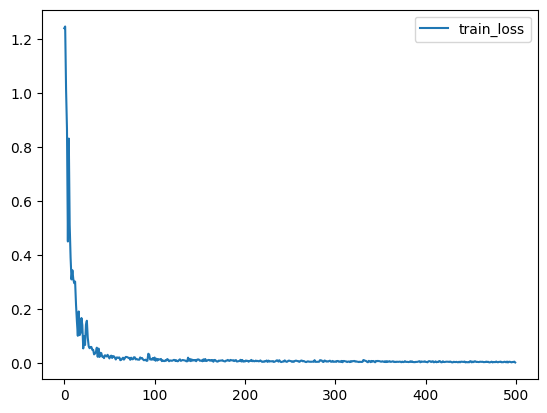

In [14]:
from matplotlib import pyplot as plt
plt.plot(np.array(loss_log), label='train_loss')
plt.legend()
plt.show

# Load test images and run inference with new model!

In [ ]:
# print(len(os.listdir("all_resize")))
# print(os.listdir("test_resize"))

In [ ]:
# Again, uncomment this decorator if you want to run inference eagerly
label_id_offset = 1

@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

In [ ]:
test_image_dir = '/content/drive/MyDrive/Comp472/all_resize'
test_images_np = []
for i in range(0, len(os.listdir(test_image_dir))):
  image_path = os.path.join(test_image_dir , str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))



for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [ ]:
%cd /content/drive/MyDrive/Comp472

# Save new pipeline config
new_pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(new_pipeline_proto, 'new_config')

exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
exported_ckpt, directory="new_config/cheakpoint", max_to_keep=5)
...
...
print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

#recover our saved Tensorflow model

In [ ]:
%ls 'new_config/cheakpoint'

In [ ]:
import pathlib

filenames = list(pathlib.Path('new_config/cheakpoint').glob('*.index'))
pipeline_file = '/content/drive/MyDrive/Comp472/new_config/pipeline.config'

filenames.sort()
print(filenames)

pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

refrence image processing

In [ ]:
%cd /content/drive/MyDrive/Comp472

In [ ]:
import PIL
from scipy.spatial.distance import euclidean
from imutils import perspective
from imutils import contours
import imutils
import cv2
from google.colab.patches import cv2_imshow
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

def scaling_function(num_pixel):
  pixel_per_metric = 24.5 / 166
  return num_pixel*pixel_per_metric

In [ ]:
#convert to hsv
img = cv2.imread('coin.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.cvtColor(img_rgb,cv2.COLOR_RGB2HSV)

# img = cv2.equalizeHist(img)

# convert to RGB
# image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = img.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)
print(pixel_values.shape)

# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# number of clusters (K)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(img.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
# kernel = np.ones((9,9),np.uint8)

grayscale = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)   #converting the color to grayscale

opening = cv2.morphologyEx(grayscale, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

cv2_imshow(closing)
cv2.waitKey(0)

In [ ]:
import numpy as np
import cv2

# Reading image
font = cv2.FONT_HERSHEY_COMPLEX

im = cv2.imread('coin.jpg')
# imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(closing.copy(), 50, 255, 0)
# plt.imshow(thresh)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours by area
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

for c in sorted_contours:


        # compute the area and perimeter
        area = cv2.contourArea(c)

        perimeter = cv2.arcLength(c, True)
        perimeter = round(perimeter, 4)
        print('Area:', area)
        print('Perimeter:', perimeter)

        x,y,w,h = cv2.boundingRect(c)
        img1 = cv2.drawContours(im, [c], -1, (0,255,255), 3)
        x1, y1 = c[0,0]
        # cv2.putText(im, f'Area:{area}', (x1-100, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        # cv2.putText(im, f'Perimeter:{perimeter}', (x1-100, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        cv2.rectangle(im, (x, y), (x + w, y + h), (255, 0,0), 1)

        cv2.putText(im, f'width:{round(scaling_function(w),2)}', (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
        cv2.putText(im, f'hiegth:{round(scaling_function(h),2)}', (x1, y1+40), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
        cv2.putText(im, "original contour, num_pts={}".format(len(c)), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)


        # calculate center and radius of minimum enclosing circle
        (x_center,y_center) ,radius = cv2.minEnclosingCircle(c)
        # cast to integers
        center = (int(x_center),int(y_center))
        radius = int(radius)
        print(center)
        print("The approximated radius is :", radius, "pixel")
        print("The approximated diameter is :", 2*radius, "pixel")

# show the original contour image
cv2_imshow(im)
cv2.destroyAllWindows()